<a href="https://colab.research.google.com/github/onuryldz54/GlobalAIHub_DeepLearning_Bootcamp/blob/main/Urban_Sound_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Urban Sound Classification

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import sys
from tqdm import tqdm
import IPython
import math
import pickle
import random
from datetime import datetime


In [5]:
pip install keras.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=f34c506b73710e976be2abf1983332405f2f4df3332dbffdf8d5b381222b7f7b
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [6]:
from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
import os
import librosa
import librosa.display
import glob 
import skimage

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%cd /content/drive/My\ Drive/Urban Sound Classification/UrbanSound8K

/content/drive/My Drive/Urban Sound Classification/UrbanSound8K


In [11]:
af = pd.read_csv("UrbanSound8K.csv")
af.shape

(8732, 8)

In [12]:
af.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [13]:
import os
import IPython.display as ipd
%cd /content/drive/My\ Drive/Urban Sound Classification/UrbanSound8K/audio
ipd.Audio('fold1/7383-3-1-0.wav')

/content/drive/My Drive/Urban Sound Classification/UrbanSound8K/audio


In [14]:
af["fold"].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

In [15]:
appended = []
for i in range(1,11):
    appended.append(af[af.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,jackhammer,dog_bark,children_playing,street_music,air_conditioner,drilling,engine_idling,siren,car_horn,gun_shot
0,fold1,120,100,100,100,100,100,96,86,36,35
1,fold2,120,100,100,100,100,100,100,91,42,35
2,fold3,120,100,100,100,100,100,107,119,43,36
3,fold4,120,100,100,100,100,100,107,166,59,38
4,fold5,120,100,100,100,100,100,107,71,98,40
5,fold6,68,100,100,100,100,100,107,74,28,46
6,fold7,76,100,100,100,100,100,106,77,28,51
7,fold8,78,100,100,100,100,100,88,80,30,30
8,fold9,82,100,100,100,100,100,89,82,32,31
9,fold10,96,100,100,100,100,100,93,83,33,32


In [16]:
af['class'].value_counts(normalize=True)

dog_bark            0.114521
children_playing    0.114521
air_conditioner     0.114521
street_music        0.114521
engine_idling       0.114521
jackhammer          0.114521
drilling            0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: class, dtype: float64

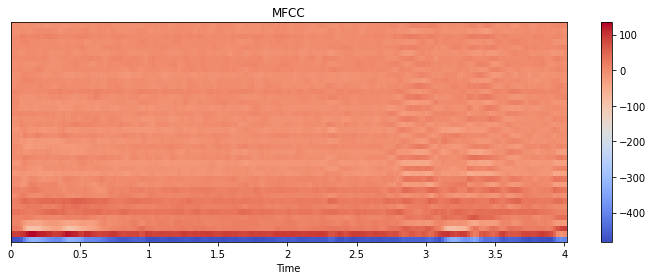

In [17]:
#MFCC 
y,sr=librosa.load("fold2/19218-3-0-0.wav")
mfccs = librosa.feature.mfcc(y, sr, n_mfcc=40)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

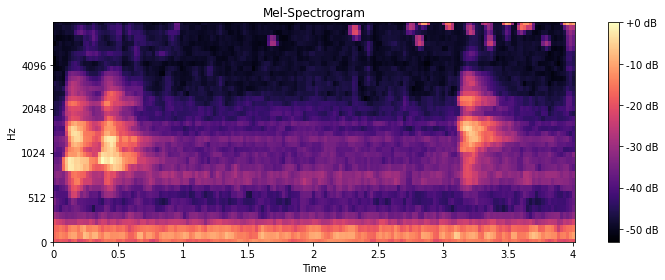

In [21]:
#Mel_Spectrogram
melspectrogram =librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.power_to_db(melspectrogram,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()

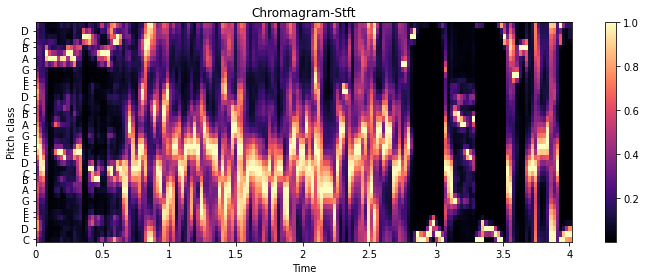

In [20]:
# Chroma_Stft
chroma_stft=librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40)
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram-Stft')
plt.tight_layout()

In [22]:
y,sr=librosa.load("fold2/19218-3-0-0.wav")
mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T,axis=0)
chroma_stft=np.mean(librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40).T,axis=0)
# tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),sr=sr).T,axis=0)
# melspectrogram.shape,chroma_stft.shape,contrast.shape,tonnetz.shape,mfccs.shape
mfccs.shape,melspectrogram.shape,chroma_stft.shape

((40,), (40,), (40,))

In [23]:
features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft)),(40,3))
features.shape

(40, 3)

In [24]:
x_train=[]
x_test=[]
y_train=[]
y_test=[]

path="fold"
for i in tqdm(range(len(af))):
    fold_no=str(af.iloc[i]["fold"])
    file=af.iloc[i]["slice_file_name"]
    label=af.iloc[i]["classID"]
    filename=path+fold_no+"/"+file
    y,sr=librosa.load(filename)
    melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T,axis=0)
    features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft)),(40,3))
    if(fold_no!='10'):
      x_train.append(features)
      y_train.append(label)
    else:
      x_test.append(features)
      y_test.append(label)


 41%|████      | 3555/8732 [20:54<38:31,  2.24it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
 95%|█████████▌| 8326/8732 [52:54<01:57,  3.45it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
 95%|█████████▌| 8329/8732 [52:55<01:42,  3.92it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
100%|██████████| 8732/8732 [55:29<00:00,  2.62it/s]


In [25]:
len(x_train)+len(x_test) # Veri setinin toplam uzunluğu.

8732

In [26]:
x=x_train+x_test
y=y_train+y_test

In [27]:
x=np.array(x) # Veri setinin array formatında tutulması.
y=np.array(y) # Veri setinin array formatında tutulması.
x.shape,y.shape

((8732, 40, 3), (8732,))

In [28]:
x_2d=np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]))
x_2d.shape

np.savetxt("x.csv", x_2d, delimiter=",")
np.savetxt("y.csv",y,delimiter=",")


In [29]:
x_2d.shape

(8732, 120)

In [30]:
indexes = []
total = len(af)
indexes = list(range(0, total))


random.shuffle(indexes)

test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


X_test = np.take(x, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(x, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

test = af.iloc[test_split_idx]
train = af.iloc[train_split_idx]

print("Test split: {} \t\t Train split: {}".format(len(test), len(train)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 3) 	 X train shape: (6986, 40, 3)
y test shape: (1746,) 		 y train shape: (6986,)


In [31]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_train.shape,y_test.shape

((6986, 10), (1746, 10))

In [32]:
X_train=np.reshape(X_train,(X_train.shape[0], 40,3))
X_test=np.reshape(X_test,(X_test.shape[0], 40,3))
X_train.shape,X_test.shape

((6986, 40, 3), (1746, 40, 3))

In [33]:
X_train=np.reshape(X_train,(X_train.shape[0], 40,3,1))
X_test=np.reshape(X_test,(X_test.shape[0], 40,3,1))
X_train.shape,X_test.shape

((6986, 40, 3, 1), (1746, 40, 3, 1))

In [34]:
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout

model=Sequential() # Modelin oluşturulması

model.add(Conv2D(64,kernel_size=3,strides=1,padding="Same",activation="relu",input_shape=(40,3,1))) # Input boyutunun 28x28 olması ve grayscaled olması sebebiyle ilk katman şekli 40,3,1 olarak belirlendi.
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(128,kernel_size=3,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(10,activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 40, 3, 64)         640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 2, 64)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 2, 128)        73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 1, 128)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 10, 1, 128)        0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)             

In [36]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

history_relu=model.fit(X_train,y_train,batch_size=36,epochs=100,validation_data=(X_test,y_test))

Epoch 1/100
195/195 [==============================] - 8s 33ms/step - loss: 2.3695 - accuracy: 0.1666 - val_loss: 2.1048 - val_accuracy: 0.2566
Epoch 2/100
195/195 [==============================] - 6s 32ms/step - loss: 2.0473 - accuracy: 0.2632 - val_loss: 1.8591 - val_accuracy: 0.3391
Epoch 3/100
195/195 [==============================] - 6s 32ms/step - loss: 1.8259 - accuracy: 0.3457 - val_loss: 1.6782 - val_accuracy: 0.4095
Epoch 4/100
195/195 [==============================] - 6s 32ms/step - loss: 1.7240 - accuracy: 0.4027 - val_loss: 1.6353 - val_accuracy: 0.4124
Epoch 5/100
195/195 [==============================] - 6s 33ms/step - loss: 1.6238 - accuracy: 0.4251 - val_loss: 1.5242 - val_accuracy: 0.4685
Epoch 6/100
195/195 [==============================] - 6s 31ms/step - loss: 1.5963 - accuracy: 0.4397 - val_loss: 1.5072 - val_accuracy: 0.4404
Epoch 7/100
195/195 [==============================] - 6s 32ms/step - loss: 1.5271 - accuracy: 0.4662 - val_loss: 1.4431 - val_accuracy:

In [37]:
train_loss_score=model.evaluate(X_train,y_train)
test_loss_score=model.evaluate(X_test,y_test)
print(train_loss_score)
print(test_loss_score)

55/55 [==============================] - 1s 9ms/step - loss: 0.7128 - accuracy: 0.7921
[0.26087498664855957, 0.9126825332641602]
[0.7127697467803955, 0.7920961976051331]


In [44]:
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.84      0.91      0.87       217
        Car Horn       0.83      0.68      0.75        95
Children Playing       0.62      0.68      0.65       210
        Dog bark       0.75      0.67      0.71       180
        Drilling       0.84      0.80      0.82       200
   Engine Idling       0.86      0.86      0.86       191
        Gun Shot       0.90      0.80      0.84        88
      Jackhammer       0.91      0.94      0.92       186
           Siren       0.75      0.88      0.81       194
    Street Music       0.73      0.63      0.68       185

        accuracy                           0.79      1746
       macro avg       0.80      0.79      0.79      1746
    weighted avg       0.79      0.79      0.79      1746



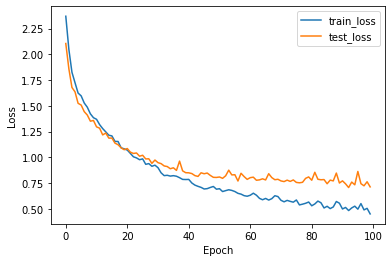

In [45]:
metrics = history_relu.history
plt.plot(history_relu.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

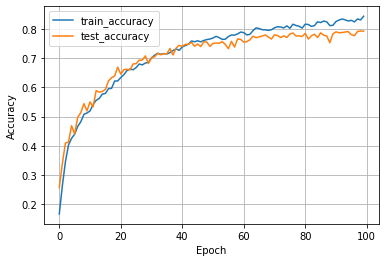

In [46]:

plt.plot(history_relu.history['accuracy'], label='train_accuracy')
plt.plot(history_relu.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

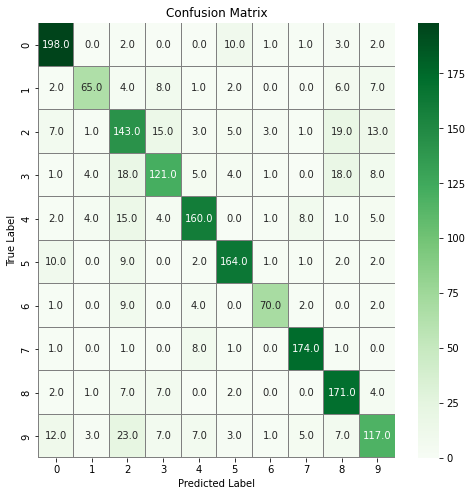

In [47]:
# confusion matrix
import seaborn as sns
import pandas as pd
import numpy as np

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()